In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('png', dpi=200)
sns.set_style('darkgrid')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report
import plotly.graph_objects as go

### Gaussian 模型

In [2]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [3]:
# 定义朴素贝叶斯模型
model = RandomForestClassifier(random_state=42)

# 定义参数网格
param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [4]:
# 绘制调参图表
results = grid_search.cv_results_
x_axis = [f"({params['n_estimators']}, {params['max_depth']}, {params['min_samples_split']}, {params['min_samples_leaf']})"
          for params in results['params']]
y_axis = results['mean_test_score']
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_axis, mode='lines+markers'))
fig.update_layout(
    title="Random Forest Parameter Optimization",
    xaxis_title="Parameter Combination",
    yaxis_title="Accuracy",
    showlegend=False, font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_1_1.html')
fig.show()

In [5]:
lr_model = grid_search.best_estimator_
lr_model

RandomForestClassifier(min_samples_leaf=4, random_state=42)

In [6]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     11190
           1       0.76      0.53      0.63      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.74      0.76     14890
weighted avg       0.83      0.84      0.83     14890



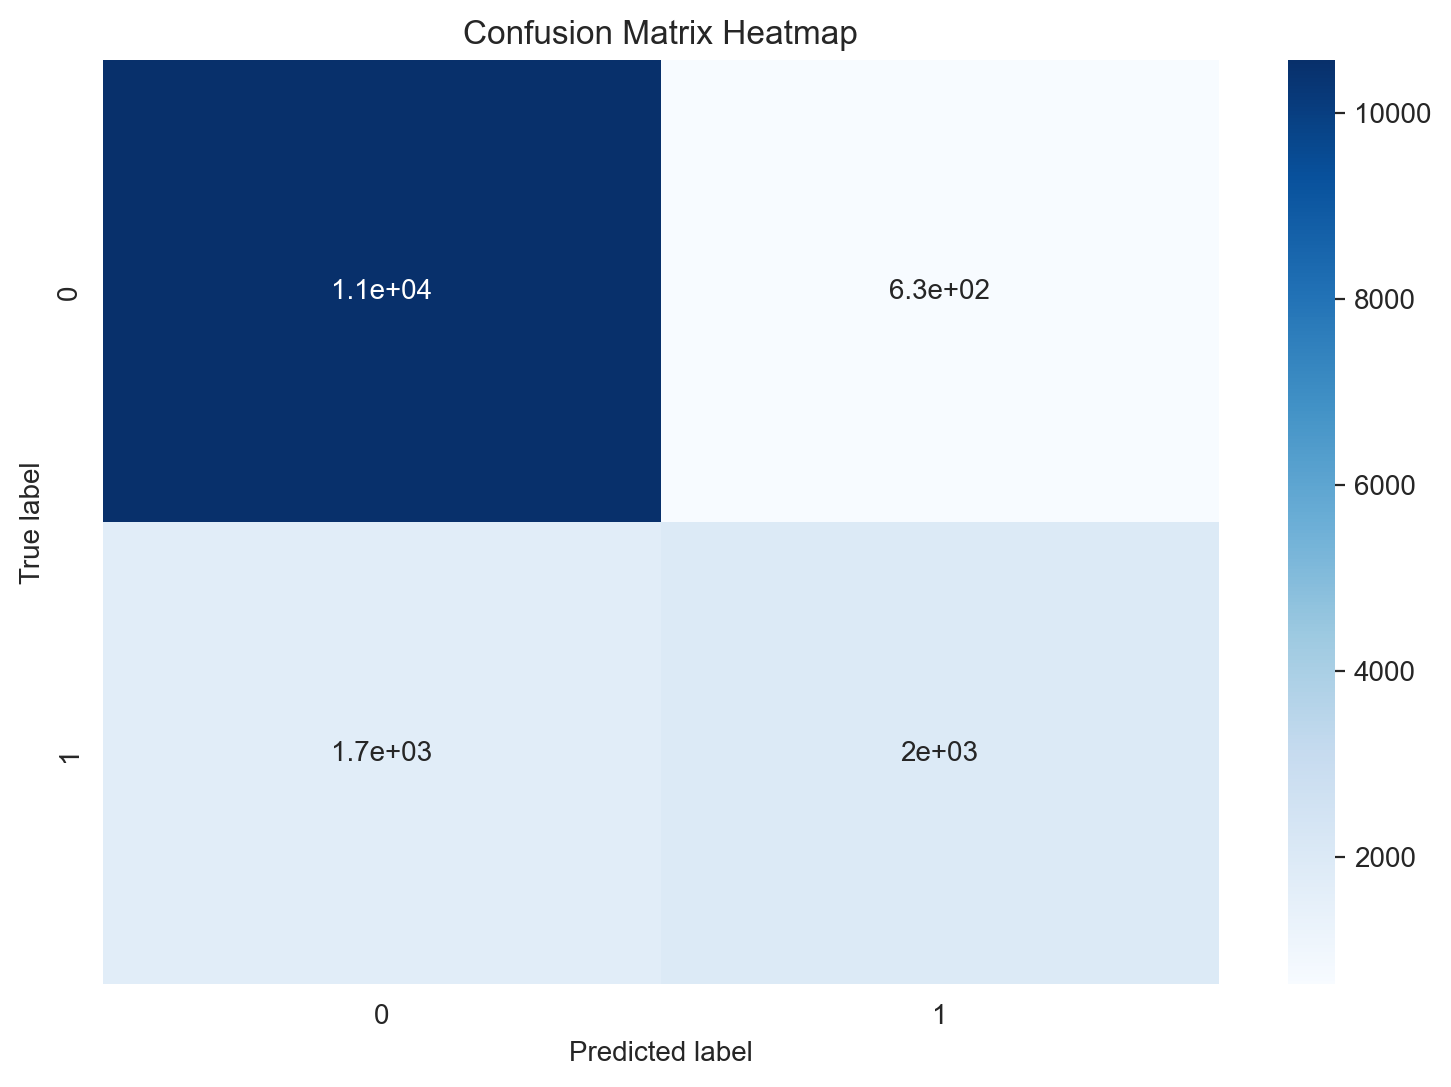

In [8]:
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [9]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_1_2.html')
# 显示图表
fig.show()

In [10]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_1_3.html')
fig.show()

### 过采样和欠采样

In [11]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')

In [12]:
from imblearn.under_sampling import RandomUnderSampler

In [13]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [14]:
# 创建欠采样器
rus = RandomUnderSampler(random_state=42)

# 进行欠采样
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [15]:
lr_model = grid_search.best_estimator_

In [16]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     11190
           1       0.76      0.53      0.63      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.74      0.76     14890
weighted avg       0.83      0.84      0.83     14890



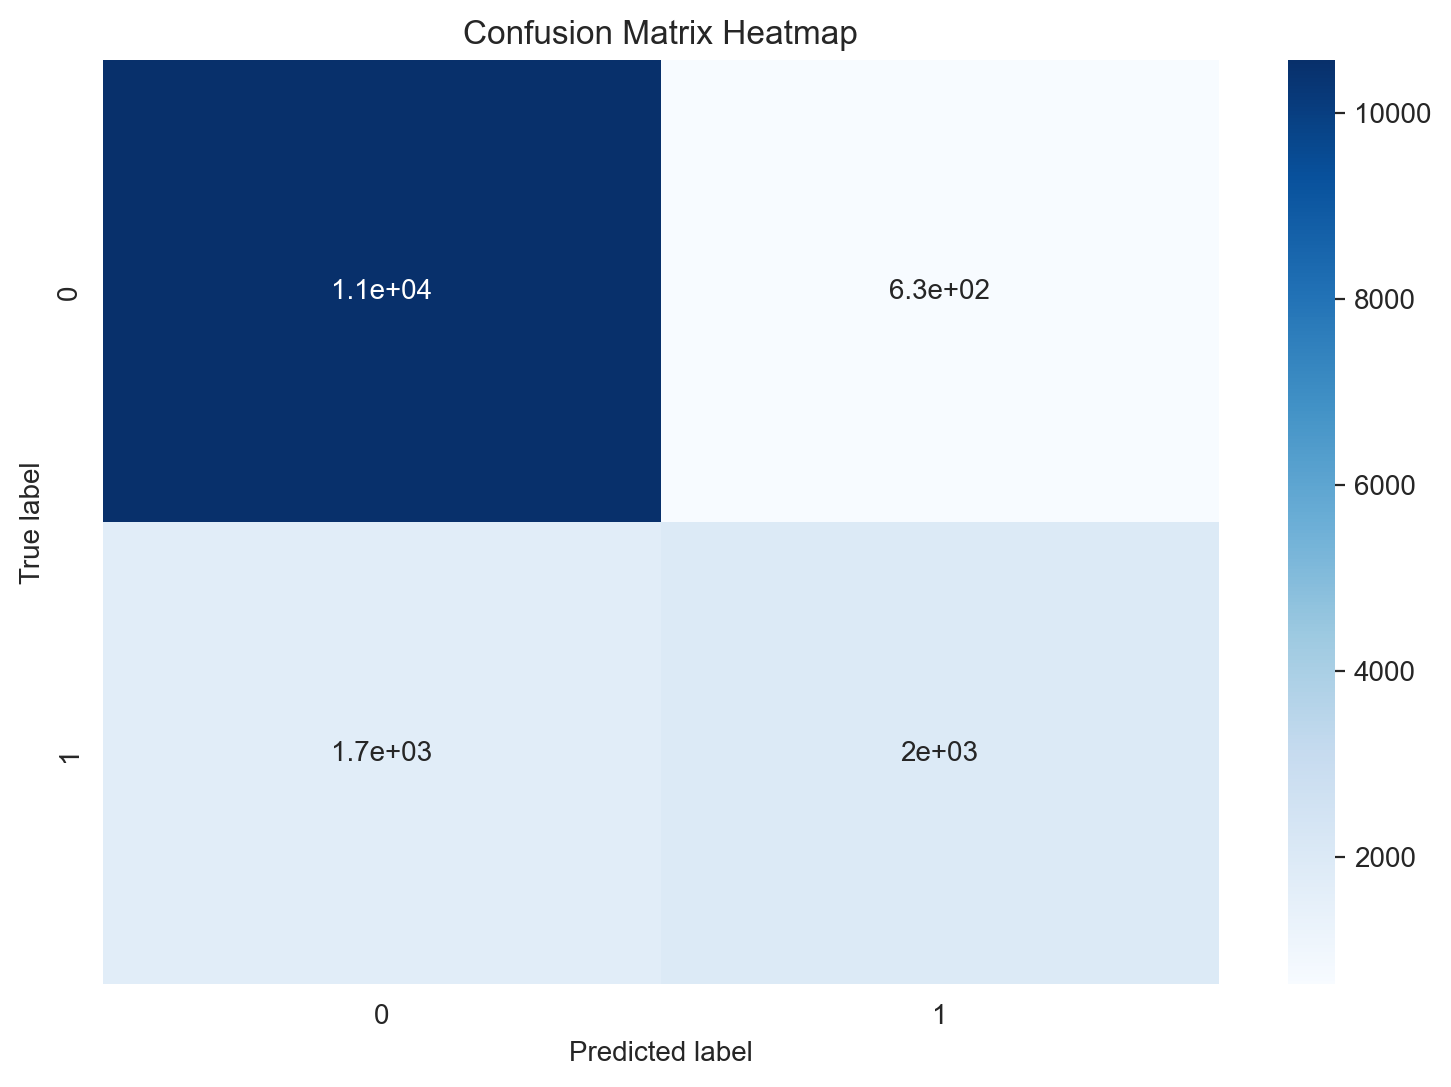

In [18]:
# %%
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [19]:
# %%
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_1_4.html')
# 显示图表
fig.show()

In [20]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_1_5.html')
fig.show()

In [21]:
train_data = pd.read_csv('Data/protrain.csv')
test_data = pd.read_csv('Data/protest.csv')

In [22]:
from imblearn.over_sampling import RandomOverSampler

In [23]:
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [24]:
# 创建过采样器
ros = RandomOverSampler(random_state=42)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [25]:
# 定义朴素贝叶斯模型
model = RandomForestClassifier(random_state=42)

# 定义参数网格
param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

# 使用网格搜索进行参数调优
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
lr_model = grid_search.best_estimator_

In [26]:
# 预测测试集结果
y_pred = lr_model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算ROC曲线数据
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     11190
           1       0.76      0.53      0.63      3700

    accuracy                           0.84     14890
   macro avg       0.81      0.74      0.76     14890
weighted avg       0.83      0.84      0.83     14890



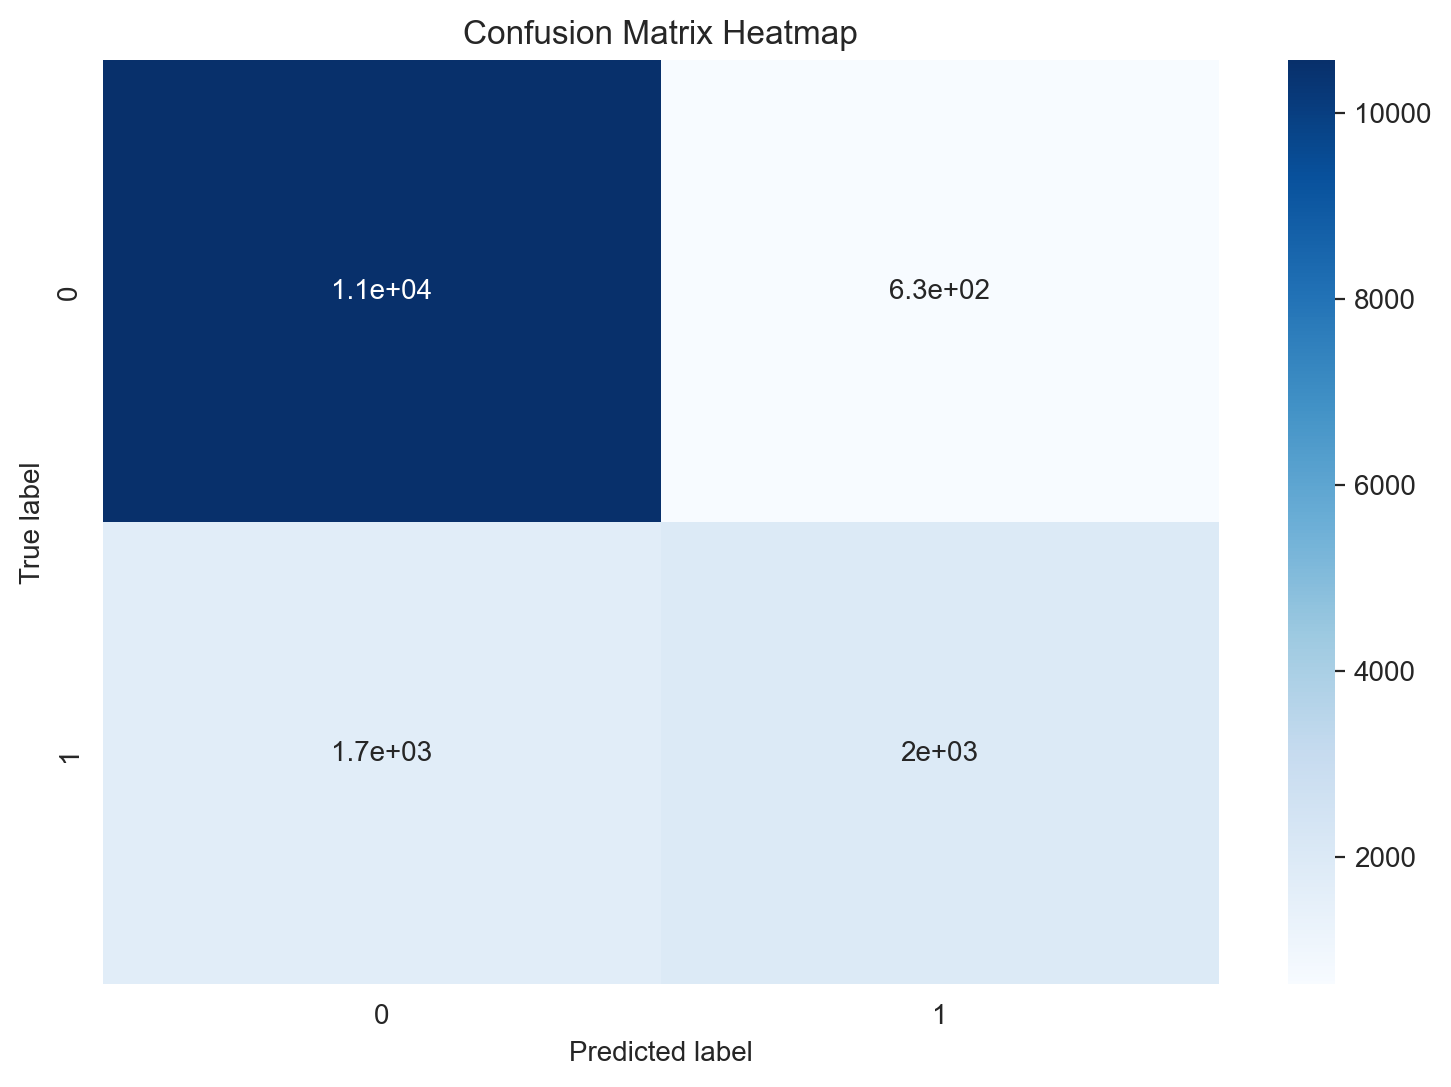

In [28]:
# %%
import seaborn as sns

fig = plt.figure(figsize=(9, 6))
# 创建混淆矩阵热力图
sns.heatmap(cm, annot=True, cmap='Blues')

# 设置图表标题和轴标签
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# 显示图表
plt.show()

In [29]:
# %%
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 计算ROC曲线
roc_auc = auc(fpr, tpr)

# 创建布局
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    hovermode='closest',
    width=900, height=600,
    font=dict(family='Times New Roman', size=18)
)

# 创建ROC曲线图形
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name='ROC curve (AUC = %0.2f)' % roc_auc
)

# 创建对角线图形
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='red', width=2, dash='dash'),
    name='Random'
)

# 创建图表数据
data = [roc_trace, diagonal_trace]

# 创建图表
fig = go.Figure(data=data, layout=layout)

fig.write_html('Image/4_6_1_6.html')
# 显示图表
fig.show()

In [30]:
# 执行交叉验证
cv_results = cross_validate(lr_model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

# 提取交叉验证结果
cv_accuracy = cv_results['test_accuracy']
cv_precision = cv_results['test_precision']
cv_recall = cv_results['test_recall']
cv_f1 = cv_results['test_f1']
cv_roc = cv_results['test_roc_auc']

# 绘制交叉验证结果的箱线图
cv_metrics_data = pd.DataFrame({
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1': cv_f1,
    'AUC': cv_roc
})

# 绘制交叉验证结果的箱线图
fig = px.box(cv_metrics_data, title='Cross Validation Metrics')
fig.update_layout(
    yaxis_title='Score', showlegend=False,
    font=dict(family='Times New Roman', size=18)
)
fig.write_html('Image/4_6_1_7.html')
fig.show()